In [20]:
pip install sklearn

  Using cached sklearn-0.0.post5-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report,  roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)
from sklearn.ensemble import (RandomForestClassifier)
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

In [22]:
pd.set_option('display.max_rows', 400)
pd.set_option('max_colwidth', 120)
pd.set_option('display.max_columns', None)

In [23]:
train = pd.read_pickle('./feature/feat_modified_v1.pkl')
train


,word_count,abstract_len,len_lead,n_comment,is_popular,is_noon,is_saturday,is_lowmonth,group_by_news_desk,feature_news_desk,group_by_section_name,feature_section_name,group_by_subsection_name,feature_subsection_name,group_by_type_of_material,feature_type_of_material,is_party,is_congress,is_president,is_ukrainian_russian_war,is_storm,is_spell,is_crossword,is_game,sentiment_vader_neg,sentiment_vader_neu,sentiment_vader_compound,sentiment_vader_compound_abs,sentiment_abstract_tb_polar,sentiment_abstract_tb_polar_abs,sentiment_abstract_tb_subj,sentiment_abstract_tb_pos,sentiment_abstract_tb_neg,sentiment_abstract_vader_neg,sentiment_abstract_vader_neu,sentiment_abstract_vader_pos,sentiment_abstract_vader_compound,sentiment_abstract_vader_compound_abs,sentiment_abstract_snow,sentiment_abstract_snow_abs
0,882,8,54,854,1,1,0,1,0.843619,0.8,0.835025,0.8,NaN,NaN,0.84,0.8,0,0,1,0,0,0,0,0,0.224,0.395,0.2960,0.2960,0.000000,0.000000,0.000000,0,1,0.000,0.680,0.320,0.5106,0.2960,0.421875,0.156251
7674,1159,16,42,409,1,0,0,1,0.843619,0.8,0.835025,0.8,NaN,NaN,0.84,0.8,0,0,0,0,0,0,0,0,0.000,0.734,0.4404,0.4404,0.400000,0.400000,0.700000,1,0,0.133,0.867,0.000,-0.2500,0.4404,0.111855,0.776289
7680,874,8,18,619,1,1,0,1,0.843619,0.8,0.835025,0.8,NaN,NaN,0.84,0.8,1,1,0,0,0,0,0,0,0.000,1.000,0.0000,0.0000,-0.472222,0.472222,0.438889,0,1,0.229,0.508,0.263,0.1010,0.0000,0.267326,0.465347
7688,1021,7,59,280,1,0,0,1,0.843619,0.8,0.835025,0.8,NaN,NaN,0.84,0.8,1,1,1,0,0,0,0,0,0.424,0.576,-0.7096,0.7096,0.100000,0.100000,0.000000,1,0,0.000,1.000,0.000,0.0000,0.7096,0.164643,0.670715
7710,1942,8,40,410,1,0,0,1,0.843619,0.8,0.835025,0.8,NaN,NaN,0.84,0.8,0,0,0,0,0,0,0,0,0.000,1.000,0.0000,0.0000,0.500000,0.500000,0.687500,1,0,0.000,0.541,0.459,0.6249,0.0000,0.396490,0.207019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18044,1537,24,41,8,0,0,0,1,0.191358,0.2,0.184397,0.2,NaN,NaN,0.00,0.0,0,0,1,0,0,0,0,0,0.183,0.488,0.3400,0.3400,0.068182,0.068182,0.477273,1,0,0.000,1.000,0.000,0.0000,0.3400,0.220917,0.558166
16621,1312,26,44,30,0,0,0,1,0.191358,0.2,0.184397,0.2,NaN,NaN,0.00,0.0,0,0,0,0,0,0,0,0,0.000,0.642,0.5994,0.5994,0.000000,0.000000,0.000000,0,1,0.000,1.000,0.000,0.0000,0.5994,0.113196,0.773608
9178,1502,11,37,10,0,0,0,1,0.191358,0.2,0.184397,0.2,NaN,NaN,0.00,0.0,0,0,0,0,0,0,0,0,0.326,0.674,-0.4404,0.4404,0.000000,0.000000,0.000000,0,1,0.237,0.763,0.000,-0.4767,0.4404,0.371652,0.256697
18081,1525,28,35,6,0,0,0,0,0.191358,0.2,0.184397,0.2,NaN,NaN,0.00,0.0,0,0,0,0,0,0,0,0,0.000,1.000,0.0000,0.0000,0.000000,0.000000,1.000000,0,1,0.153,0.801,0.045,-0.4767,0.0000,0.039727,0.920546


In [24]:

X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X
y


0        1
7674     1
7680     1
7688     1
7710     1
        ..
18044    0
16621    0
9178     0
18081    0
17214    0
Name: is_popular, Length: 20112, dtype: int64

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
feature_names = X_train.columns

In [34]:
models = {'svc': SVC(random_state=42, probability=True),
          'rf': RandomForestClassifier(random_state=42),
          'xgb': XGBClassifier(seed=42, use_label_encoder=False, eval_metric='auc')}

c:\Users\權祐吳\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [35]:
class CustomTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# This function takes a dataframe as input and returns a scaled version
def scale_df(input_df):
    ss = StandardScaler()
    feature_names = input_df.columns
    input_df = ss.fit_transform(input_df)
    input_df = pd.DataFrame(input_df, columns=feature_names)
    return input_df

In [36]:
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', CustomTransformer(scale_df)),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs.best_estimator_
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    
    results['model'] = mod
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe[1])
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [37]:
svc = run_model('svc')

### METRICS ###


{'model': 'svc',
 'train_auc': 0.8674249312547184,
 'test_auc': 0.8053743963261646,
 'precision': 0.7647577092511013,
 'specificity': 0.9371172868582195,
 'recall': 0.4854586129753915,
 'f_score': 0.5939103660622648}

True Negatives: 3979
False Positives: 267
False Negatives: 920
True Positives: 868


In [38]:
rf = run_model('rf')

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9999143583927594,
 'test_auc': 0.8459441627387693,
 'precision': 0.7375669472073451,
 'specificity': 0.91921808761187,
 'recall': 0.5391498881431768,
 'f_score': 0.6229402261712439}

True Negatives: 3903
False Positives: 343
False Negatives: 824
True Positives: 964


In [39]:
xgb = run_model('xgb')

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9750533631900492,
 'test_auc': 0.8394286871918404,
 'precision': 0.7098214285714286,
 'specificity': 0.9081488459726802,
 'recall': 0.5335570469798657,
 'f_score': 0.6091954022988506}

True Negatives: 3856
False Positives: 390
False Negatives: 834
True Positives: 954


In [40]:
pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)

,model,train_auc,test_auc,precision,specificity,recall,f_score
0,rf,0.999914,0.845944,0.737567,0.919218,0.539150,0.622940
1,xgb,0.975053,0.839429,0.709821,0.908149,0.533557,0.609195
2,svc,0.867425,0.805374,0.764758,0.937117,0.485459,0.593910


In [ ]:
svc_params = {
    'svc__C':[0.05, 1, 0.04, 0.06, 0.045, 0.9, 0.8, 0.7, 0.6],
    'svc__gamma':[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.04, 0.03, 0.02], 
    'svc__kernel':['rbf', 'sigmoid'],
}
svc_gs =  run_model('svc', mod_params=svc_params, grid_search=True)

In [12]:
svc_params = {
    'svc__C':[0.6],
    'svc__gamma':[0.02], 
    'svc__kernel':['rbf', 'sigmoid'],
}
svc_gs =  run_model('svc', mod_params=svc_params, grid_search=True)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
### BEST PARAMS ###


SVC(C=0.6, gamma=0.02, probability=True, random_state=42)

### METRICS ###


{'model': 'svc',
 'train_auc': 0.8462637702994646,
 'test_auc': 0.8316010377453666,
 'precision': 0.7784846732215154,
 'specificity': 0.813715953307393,
 'recall': 0.6842907981698018,
 'f_score': 0.7283549783549783}

True Negatives: 1673
False Positives: 383
False Negatives: 621
True Positives: 1346


In [ ]:
rf_params = {'rf__n_estimators': [100, 200, 300, 400, 500],
             'rf__max_depth': [10, 20, 30, 40, 50, 60],
             'rf__min_samples_leaf': [i for i in range(2, 18)],
            }
rf_gs =  run_model('rf', mod_params=rf_params, grid_search=True)

In [ ]:
xgb_params = { 
              'xgb__learning_rate' : [0.05, 0.1, 0.3],
              'xgb__max_depth' : [6, 7], 
              'xgb__n_estimators' : [100, 150],
              'xgb__reg_alpha' : [0, 1, 2],
              'xgb__reg_lambda' : [0, 1, 2],
              'xgb__gamma' : [0, 1, 3],
            }
xgb_gs = run_model('xgb', mod_params=xgb_params, grid_search=True)

In [26]:
gs_df = pd.DataFrame(gs_list)
gs_df.sort_values(by='test_auc', ascending=False)

,model,train_auc,test_auc,precision,specificity,recall,f_score
1,rf,0.978106,0.854554,0.766187,0.778696,0.758007,0.762075
0,svc,0.846264,0.831601,0.778485,0.813716,0.684291,0.728355


In [27]:
gs_dict = {
    svc_gs: 'SupportVectorMachineClf',
    rf_gs: 'RandomForest',
}

In [28]:
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = sklearn.metrics.RocCurveDisplay.from_estimator(m, X_test, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('gray')
                axes[a].line_.set_alpha(0.25)
                
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

In [29]:
print(sklearn.__version__)

1.2.2


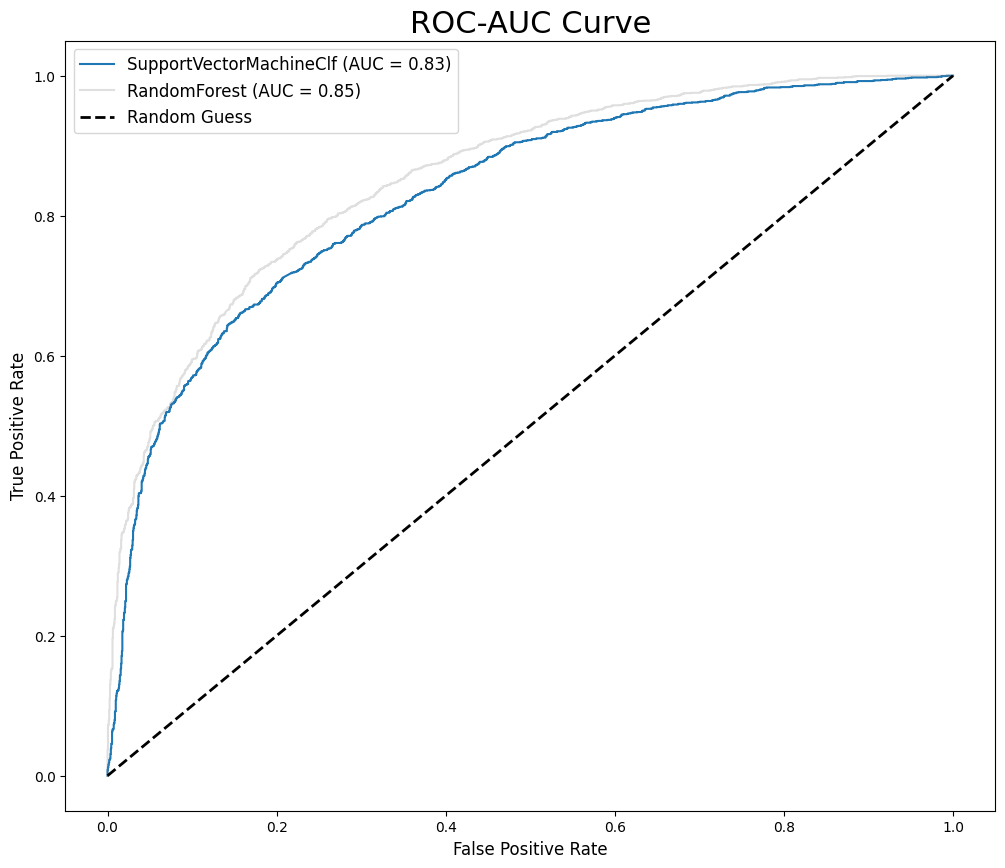

In [31]:
roc_curve_plotter(gs_dict, True)